In [295]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE

In [296]:
# load the data
train_ds = np.load('train_data.npz')
val_ds = np.load('val_data.npz')
test_ds = np.load('test_data.npz')

In [297]:
print(train_ds.files)
print(val_ds.files)
print(test_ds.files)

['imgs', 'labels']
['imgs', 'labels']
['imgs']


In [298]:
print("Shape of train_ds images:", train_ds['imgs'].shape)  
print("Shape of train_ds labels:", train_ds['labels'].shape)
print("Shape of val_ds images:", val_ds['imgs'].shape)  
print("Shape of val_ds labels:", val_ds['labels'].shape)
print("Shape of test_ds images:", test_ds['imgs'].shape)  

Shape of train_ds images: (4708, 28, 28)
Shape of train_ds labels: (4708, 1)
Shape of val_ds images: (524, 28, 28)
Shape of val_ds labels: (524, 1)
Shape of test_ds images: (624, 28, 28)


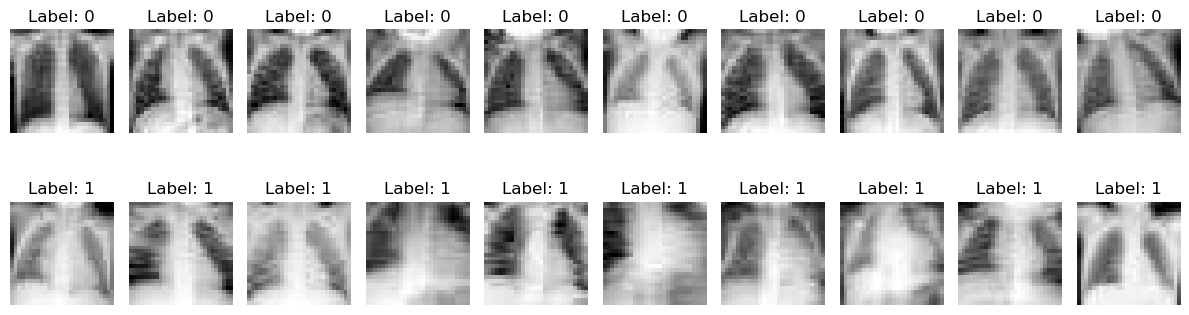

In [299]:
num_samples = 10
sample_zero_indexes = np.where(train_ds['labels'] == 0)[0][:num_samples]
sample_one_indexes = np.where(train_ds['labels'] == 1)[0][:num_samples]

fig, axes = plt.subplots(2, num_samples, figsize=(12, 4)) # Adjust figsize as needed

for index_0, index_1 in zip(sample_zero_indexes, sample_one_indexes):
    axes[0, np.where(sample_zero_indexes == index_0)[0][0]].imshow(train_ds['imgs'][index_0], cmap='gray')
    axes[0, np.where(sample_zero_indexes == index_0)[0][0]].axis('off')
    axes[0, np.where(sample_zero_indexes == index_0)[0][0]].set_title('Label: 0')

    axes[1, np.where(sample_one_indexes == index_1)[0][0]].imshow(train_ds['imgs'][index_1], cmap='gray')
    axes[1, np.where(sample_one_indexes == index_1)[0][0]].axis('off')
    axes[1, np.where(sample_one_indexes == index_1)[0][0]].set_title('Label: 1')

plt.tight_layout()
plt.show()

In [300]:
def compute_covariance_matrix(X):
    X = X.reshape(X.shape[0], -1)  
    X_centered = X - np.mean(X, axis=0)
    return np.cov(X_centered, rowvar=False)

In [301]:
def perform_pca(X, num_components):
    covariance_matrix = compute_covariance_matrix(X)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    selected_eigenvectors = sorted_eigenvectors[:, :num_components]
    X_centered = X.reshape(X.shape[0], -1) - np.mean(X.reshape(X.shape[0], -1), axis=0)
    X_reduced = np.dot(X_centered, selected_eigenvectors)
    return X_reduced, selected_eigenvectors, sorted_eigenvalues[:num_components]

In [302]:
def pca_transform(X, eigenvectors):
    X_centered = X.reshape(X.shape[0], -1) - np.mean(X.reshape(X.shape[0], -1), axis=0)
    return np.dot(X_centered, eigenvectors)

In [303]:
total_variance = np.sum(compute_covariance_matrix(train_ds['imgs']).diagonal())
explained_variances = []
desired = 0.95
num_components=1
explained_variance = 0
while explained_variance < desired:
    _, _, eigenvalues = perform_pca(train_ds['imgs'], num_components)
    explained_variance = np.sum(eigenvalues) / total_variance
    explained_variances.append(explained_variance)
    num_components += 1


In [304]:
num_components_list = list(range(1, len(explained_variances) + 1))
print(f"Number of components to explain at least {desired*100}% variance: {num_components - 1}")
percentage_explained_variances = [var * 100 for var in explained_variances]

Number of components to explain at least 95.0% variance: 71


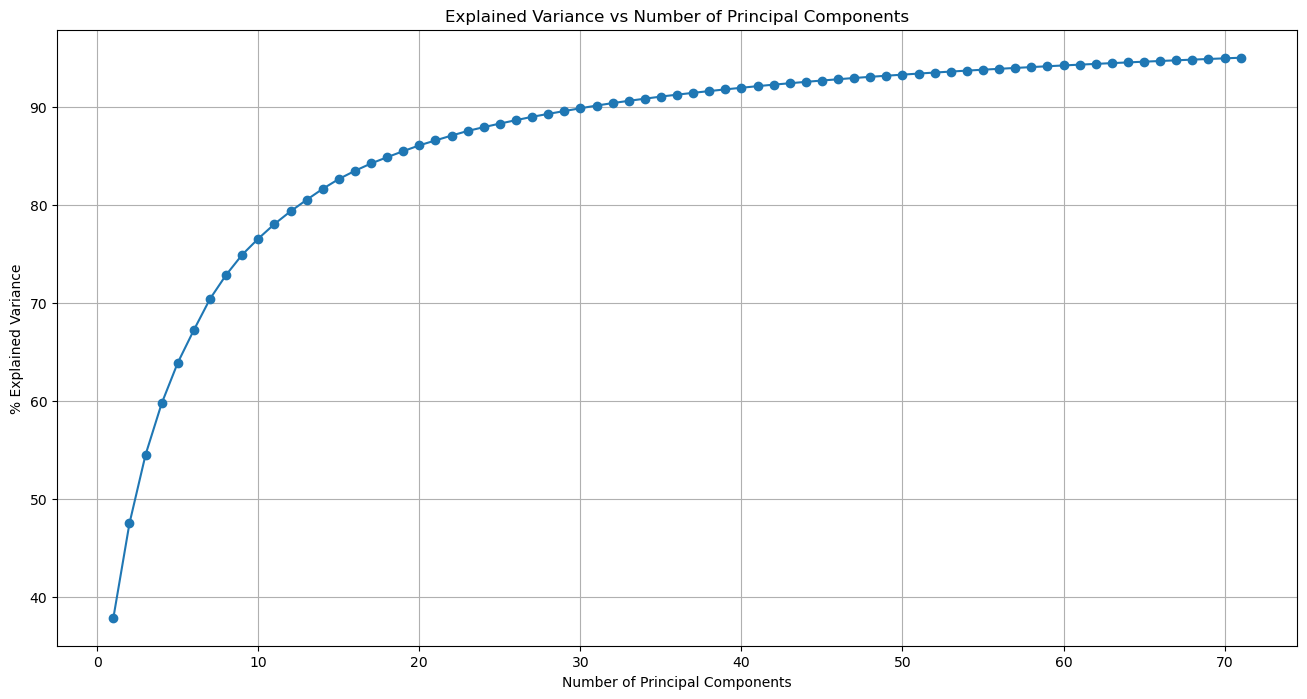

In [305]:
plt.figure(figsize=(16, 8))
plt.plot(num_components_list, percentage_explained_variances, marker='o')
plt.title('Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('% Explained Variance')
# plt.xticks(num_components_list)
plt.grid()
plt.show()

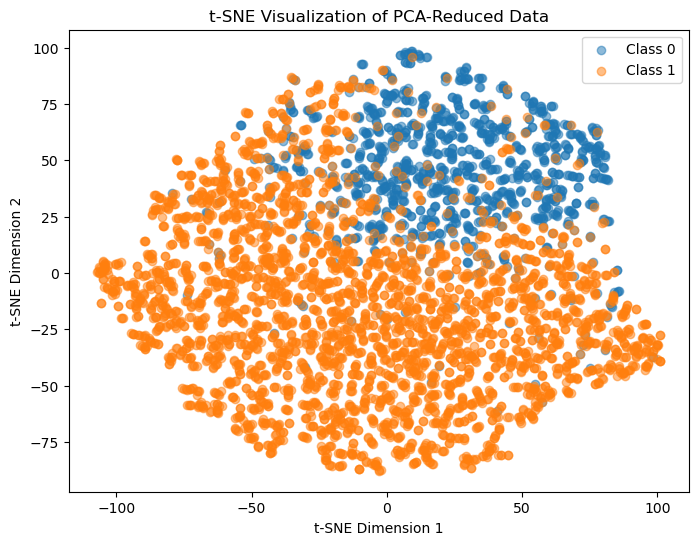

In [306]:
X_reduced, _, _ = perform_pca(train_ds['imgs'], 71) 
labels = train_ds['labels'].ravel()  
tsne = TSNE(n_components=2, perplexity=4, random_state=42, init='pca', learning_rate='auto', max_iter=1000)
X_tsne = tsne.fit_transform(X_reduced)
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[labels == 0, 0], X_tsne[labels == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_tsne[labels == 1, 0], X_tsne[labels == 1, 1], label='Class 1', alpha=0.5)
plt.title('t-SNE Visualization of PCA-Reduced Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [307]:
X_reduced_train, eigenvectors, _ = perform_pca(train_ds['imgs'], 71)
X_reduced_val = pca_transform(val_ds['imgs'], eigenvectors)
X_reduced_test = pca_transform(test_ds['imgs'], eigenvectors)

In [308]:
print(f"Train shape {X_reduced_train.shape}")
print(f"Train shape {X_reduced_val.shape}")
print(f"Train shape {X_reduced_test.shape}")

Train shape (4708, 71)
Train shape (524, 71)
Train shape (624, 71)


In [309]:
def sigmoid(z):
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1 / (1 + np.exp(-z))

In [310]:
def predict(X, w,b):
    z = np.dot(X, w) + b
    return sigmoid(z)

In [311]:
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(1 / m) * np.sum(
        y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    )

In [365]:
def logistic_regression(train_data, train_labels, val_data, val_labels, lr, epochs, patience, threshold, reg_lambda):
    train_labels = train_labels.ravel()
    val_labels = val_labels.ravel()
    n_sample, n_feature = train_data.shape
    
    w = np.zeros(n_feature)
    b = 0.0
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_loss = float("inf")
    best_w, best_b = None, None
    patience_counter = 0
    
    for t in range(epochs):
        z = np.dot(train_data, w) + b
        y_pred = sigmoid(z)
        loss = -(np.dot(train_labels, np.log(y_pred + 1e-5)) + np.dot((1 - train_labels), np.log(1 - y_pred + 1e-5))) / n_sample
        y_class = (y_pred >= threshold).astype(int)
        train_acc = (y_class == train_labels).mean()
        z_val = np.dot(val_data, w) + b
        y_val = sigmoid(z_val)
        val_loss = -(np.dot(val_labels, np.log(y_val + 1e-5)) +  np.dot((1 - val_labels), np.log(1 - y_val + 1e-5))) / len(val_labels)
        y_val_class = (y_val >= threshold).astype(int)
        val_acc = (y_val_class == val_labels).mean()
        
        # if (t+1) % 50 == 0:
        train_losses.append(loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc*100)
        val_accuracies.append(val_acc*100)
        #     print(f"Epoch {t+1}/{epochs}, Train Loss: {loss:.4f}, Train Acc: {train_acc*100:.4f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.4f}%")
        dw = (1/n_sample) * np.dot(train_data.T, (y_pred - train_labels)) +  reg_lambda*w  # L2 regularization
        db = (1/n_sample) * np.sum(y_pred - train_labels)
        
        w -= lr * dw
        b -= lr * db
        
        # Early stopping check
        if val_loss < best_val_loss - 1e-6:  
            best_val_loss = val_loss
            best_w, best_b = w.copy(), b
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {t+1}")
                break
    
    # Restore best weights
    if best_w is not None:
        w, b = best_w, best_b
    
    return w, b, train_losses, val_losses, train_accuracies, val_accuracies


In [366]:
threshold=0.336
w, b, train_losses, val_losses, train_accuracies, val_accuracies = logistic_regression(X_reduced_train, train_ds['labels'], X_reduced_val, val_ds['labels'], lr=0.00001, epochs=1600, patience=75, threshold=threshold, reg_lambda=1e-5)

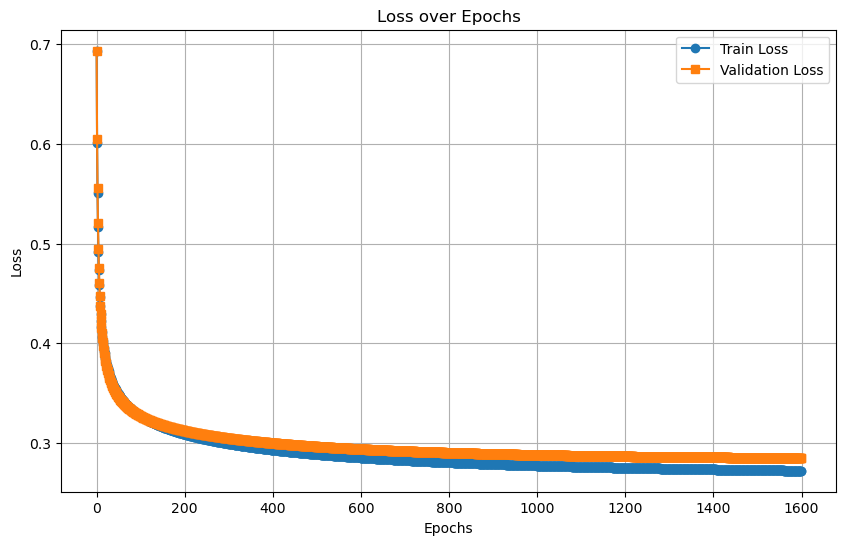

In [367]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses,marker = 'o', label='Train Loss', alpha = 1)
plt.plot(val_losses,marker = 's', label='Validation Loss', alpha=1)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



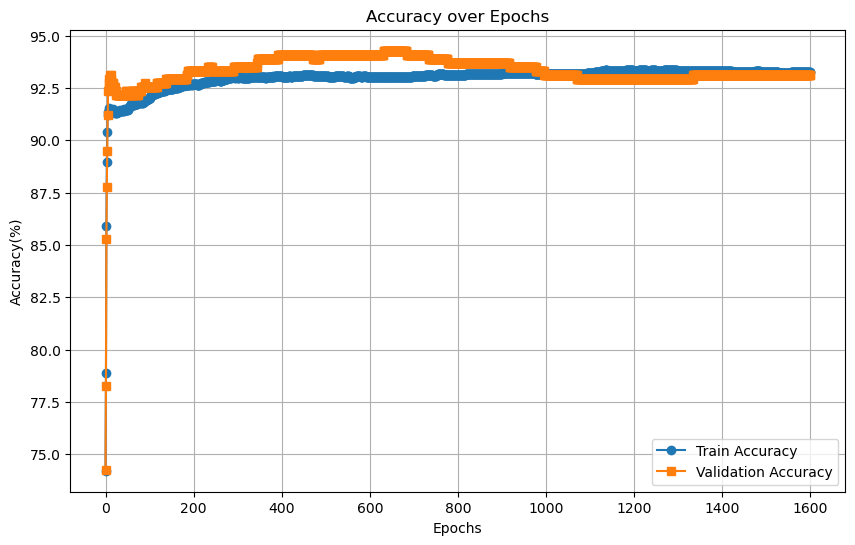

In [368]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy',marker = 'o')
plt.plot(val_accuracies, label='Validation Accuracy',marker = 's')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
# plt.yticks(np.arange(np.roundnp.min(train_accuracies)-5,np.max(train_accuracies)+2))
plt.grid(True)
plt.legend()
plt.show()

### Performance metric
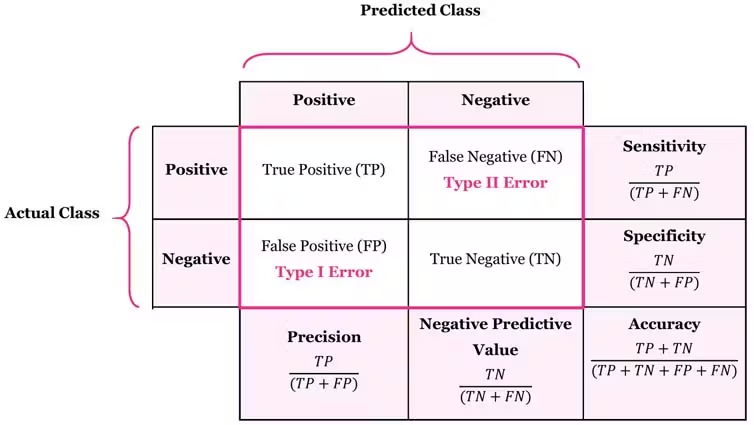

In [382]:
def accuracy_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true==1) & (y_pred==0))
    tn = np.sum((y_true==0) & (y_true==0))
    return (tp+tn)*100/(tp+tn+fp+fn + 1e-15)

In [369]:
def precision_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp*100 / (tp + fp + 1e-15) # Returning percentage

In [370]:
def recall_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp*100 / (tp + fn + 1e-15) # Returning percentage

In [371]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-15)
    recall = tp / (tp + fn + 1e-15)

    return 2*100 * (precision * recall) / (precision + recall + 1e-15) # Returning percentage

In [372]:
train_predictions = (predict(X_reduced_train, w, b) >= threshold).astype(int)
val_predictions = (predict(X_reduced_val, w, b) >= threshold).astype(int)

In [373]:
y_train = train_ds['labels'].ravel()
y_val = val_ds['labels'].ravel()

In [383]:
print("Training Set Metrics:")
print(f"Accuracy: {accuracy_score(y_train, train_predictions):.3f}%")
print(f"Precision: {precision_score(y_train, train_predictions):.3f}%")
print(f"Recall: {recall_score(y_train, train_predictions):.3f}%")
print(f"F1-Score: {f1_score(y_train, train_predictions):.3f}%")

Training Set Metrics:
Accuracy: 93.343%
Precision: 98.356%
Recall: 92.473%
F1-Score: 95.324%


In [384]:
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_score(y_val, val_predictions):.3f}%")
print(f"Precision: {precision_score(y_val, val_predictions):.3f}%")
print(f"Recall: {recall_score(y_val, val_predictions):.3f}%")    
print(f"F1-Score: {f1_score(y_val, val_predictions):.3f}%")

Validation Set Metrics:
Accuracy: 93.246%
Precision: 97.574%
Recall: 93.059%
F1-Score: 95.263%


In [376]:
y_test_pred = predict(X_reduced_test, w, b)
y_test_class = (y_test_pred >= 0.5).astype(int)
y_test_class = y_test_class.reshape(-1, 1)
os.makedirs("Assignment1/Q3", exist_ok=True)
np.savez("Assignment1/Q3/LogisticRegressionPreds.npz", test_preds=y_test_class)
print("Saved predictions with shape:", y_test_class.shape)

Saved predictions with shape: (624, 1)
